# Polarization splitter and rotator based on 90 degree bends

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

Efficient manipulation of the polarization state of light is essential for many photonic applications including optical communications, quantum information processing, and sensing. Polarization beam splitters and rotators (PSRs) are key devices that can split an input beam into two TE and TM output beams and rotate the TM beam into TE polarization. This notebook presents the simulation of a compact and highly efficient PSR based on 90 degree bends in a silicon-on-insulator platform. The design is proposed in the work `Kang Tan, Ying Huang, Guo-Qiang Lo, Chengkuo Lee, and Changyuan Yu, "Compact highly-efficient polarization splitter and rotator based on 90° bends," Opt. Express 24, 14506-14512 (2016)` [DOI: 10.1364/OE.24.014506](https://doi.org/10.1364/OE.24.014506) and experimentally demonstrated in `Kang Tan, Ying Huang, Guo-Qiang Lo, Changyuan Yu, and Chengkuo Lee, "Experimental realization of an O-band compact polarization splitter and rotator," Opt. Express 25, 3234-3241 (2017)` [DOI: 10.1364/OE.25.003234](https://doi.org/10.1364/OE.25.003234).

The proposed PSR consists of two parallel 90 degree bend waveguides with slightly different cross-sections designed for phase matching between the TM mode of the inner bend and the TE mode of the outer bend. The inner bend is designed to strongly confine the TE mode while allowing the TM mode to couple to the outer bend. By optimizing the geometry, efficient polarization splitting and rotating with low loss and high extinction ratio is achieved in a compact device footprint.

<img src="img/90_bend_PSR_1.png" width="300" alt="Schematic of the PSR">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

## Simulation Setup

Define simulation wavelength range to be 1.25 μm to 1.37 μm, covering the entire O-band.

In [2]:
lda0 = 1.31  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.25, 1.37, 21)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency

In this device, the PSR is made of silicon. The cladding and substrate are made of silicon oxide. We will simply use the popularly used refractive index data from Palik by calling Tidy3D's built-in [material library](../api/material_library.html).

In [3]:
# define silicon medium
si = td.material_library["cSi"]["Palik_Lossless"]

# define silicon oxide medium
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

Define the geometric parameters. The inner bend is fully etched while the outer bend is partially etched. The cross section is schematically shown below.

<img src="img/90_bend_PSR_2.png" width="400" alt="Cross section of the waveguides">

In [4]:
R1 = 10  # radius of the inner bend
H1 = 0.22  # thickness of the fully etched waveguide
W1 = 0.4  # width of the inner bend waveguide
Wg = 0.2  # width of the gap
W2 = 0.21  # width of the fully etched outer waveguide
W3 = 0.285  # width of the partially etched outer waveguide
H2 = 0.11  # thickness of the partially etched waveguide
buffer = 5  # buffer spacing

Since the PSR contains various bending parts, the easiest way to define the geometry is to use the `gdstk` library. 

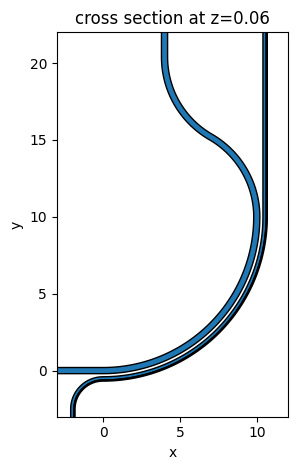

In [5]:
# define a gds cell
cell = gdstk.Cell("psi")

# radius of the s bend
s_bend_radius = 6
# angle of the s bend
s_bend_angle = np.pi / 3

# define the inner bend path
inner_path = gdstk.RobustPath(
    initial_point=(-buffer, 0), width=W1, tolerance=1e-4, layer=1, datatype=0
)
inner_path.horizontal(x=0)
inner_path.arc(radius=R1, initial_angle=-np.pi / 2, final_angle=0)
inner_path.arc(radius=s_bend_radius, initial_angle=0, final_angle=s_bend_angle)
inner_path.arc(radius=s_bend_radius, initial_angle=-np.pi + s_bend_angle, final_angle=-np.pi)
inner_path.vertical(y=buffer, relative=True)
cell.add(inner_path)

# starting coordinates of the outer bend path
x0 = -2
y0 = -2

# define the fully etched outer bend path
outer_path = gdstk.RobustPath(
    initial_point=(x0, -buffer), width=W2, tolerance=1e-4, layer=1, datatype=0
)
outer_path.vertical(y=-W1 / 2 - Wg - W2 / 2 + y0)
outer_path.arc(radius=2, initial_angle=np.pi, final_angle=np.pi / 2)
outer_path.arc(radius=R1 + W1 / 2 + Wg + W2 / 2, initial_angle=-np.pi / 2, final_angle=0)
outer_path.vertical(y=buffer * 3, relative=True)
cell.add(outer_path)

# define the partially etched outer bend path
partially_etched_path = gdstk.RobustPath(
    initial_point=(-2 + W3 / 2, -buffer), width=W3 - W2, tolerance=1e-4, layer=2, datatype=0
)
partially_etched_path.vertical(y=-W1 / 2 - Wg - W2 / 2 + y0)
partially_etched_path.arc(radius=2 - W3 / 2, initial_angle=np.pi, final_angle=np.pi / 2)
partially_etched_path.arc(
    radius=R1 + W1 / 2 + Wg + W2 / 2 + W3 / 2, initial_angle=-np.pi / 2, final_angle=0
)
partially_etched_path.vertical(y=buffer * 3, relative=True)
cell.add(partially_etched_path)

# define structures from the gds
inner_bend = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, H1),
    )[0],
    medium=si,
)

outer_bend = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, H1),
    )[1],
    medium=si,
)

partially_etched_bend = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=2,
        axis=2,
        slab_bounds=(0, H2),
    )[0],
    medium=si,
)

# plot the structures to visualize
ax = inner_bend.plot(z=H2 / 2)
ax = outer_bend.plot(z=H2 / 2, ax=ax)
partially_etched_bend.plot(z=H2 / 2, ax=ax)

# define simulation domain bounds
x_min = -3
x_max = 12
y_min = -3
y_max = 22
z_min = -1
z_max = 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.show()

Define a [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) first to launch the TM mode at the input waveguide. Later, we will also simulate a TE mode source. `mode_index=1` specifies that we are selecting the TM0 mode while `mode_index=0` corresponds to the TE0 mode since they are ordered by their effective index values in a decreasing order.

To measure mode conversion efficiencies at the through and cross ports, we define two [ModeMonitors](../api/_autosummary/tidy3d.ModeMonitor.html). We also define a [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) to help visualize the mode propagation and conversion. 

In [6]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=2, target_neff=3.5)
mode_source = td.ModeSource(
    center=(-lda0, 0, H1 / 2),
    size=(0, 4 * W1, 6 * H1),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=1,
)

# add a mode monitor to measure transmission at the cross port
mode_monitor_cross = td.ModeMonitor(
    center=(R1 + W1 / 2 + Wg + W2 / 2 + W3 / 2, R1 + 2 * buffer, H1 / 2),
    size=(8 * W1, 0, 6 * H1),
    freqs=freqs,
    mode_spec=mode_spec,
    name="cross",
)

# add a mode monitor to measure transmission at the through port
mode_monitor_through = td.ModeMonitor(
    center=(4, R1 + 2 * buffer, H1 / 2),
    size=(8 * W1, 0, 6 * H1),
    freqs=freqs,
    mode_spec=mode_spec,
    name="through",
)

# add a field monitor to visualize field distribution at z=t/2
field_monitor = td.FieldMonitor(
    center=(0, 0, H2 / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

Define a Tidy3D simulation. Rememeber to set `medium=sio2`, which makes the background medium silicon oxide instead of air. To ensure good accuracy, we use an automatic nonuniform grid with `min_steps_per_wvl=20`.

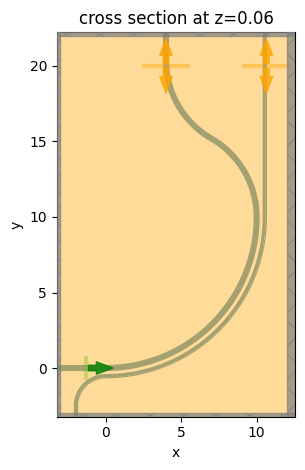

In [7]:
run_time = 1e-12  # simulation run time

# define a simulation domain box
sim_box = td.Box.from_bounds(rmin=(x_min, y_min, z_min), rmax=(x_max, y_max, z_max))

# construct simulation
sim_tm = td.Simulation(
    center=sim_box.center,
    size=sim_box.size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[inner_bend, outer_bend, partially_etched_bend],
    sources=[mode_source],
    monitors=[mode_monitor_cross, mode_monitor_through, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

# plot simulation
sim_tm.plot(z=H2 / 2)
plt.show()

To have a better visualization, we can also plot the simulation in 3D.

In [8]:
sim_tm.plot_3d()

## Mode Analysis

To analyze the working principle of the design, we need to perform mode solving for the outer bend waveguide. To ensure sufficient accuracy, we will run the mode solving in the server, where subpixel averaging is applied. First, solve for two modes and plot the mode profiles.

16:40:28 PST Mode solver created with                                           
             task_id='fdve-d70b0194-228e-46ac-a57d-41b009550e1b',               
             solver_id='mo-36dd48a9-6680-4b56-90a4-53fd248ac189'.

Output()

Output()

16:40:30 PST Mode solver status: queued

16:40:43 PST Mode solver status: running

16:41:04 PST Mode solver status: success

Output()

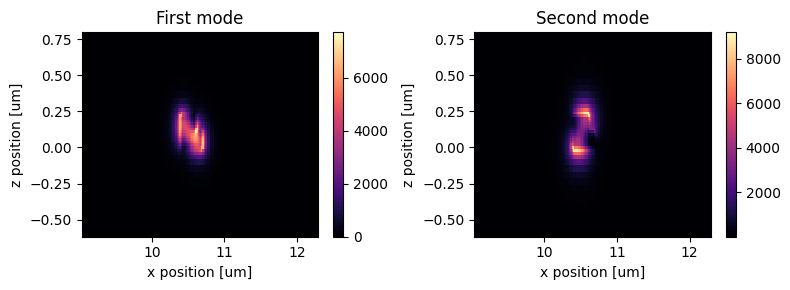

In [9]:
mode_solver = ModeSolver(
    simulation=sim_tm,
    plane=td.Box(center=mode_monitor_cross.center, size=mode_monitor_cross.size),
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data_outer = run_mode_solver(mode_solver)


def plot_field_intensity(mode_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
    cmap = "magma"
    mode_data.intensity.sel(mode_index=0, f=freq0).plot(x="x", y="z", cmap=cmap, ax=ax1)
    mode_data.intensity.sel(mode_index=1, f=freq0).plot(x="x", y="z", cmap=cmap, ax=ax2)
    ax1.set_title("First mode")
    ax2.set_title("Second mode")


plot_field_intensity(mode_data_outer)

We can also plot the field components to better visualize the polarizations of the modes. The first mode is TE-like as the dominant field component is $E_x$ while the second mode is TM-like with the dominant component being $E_z$

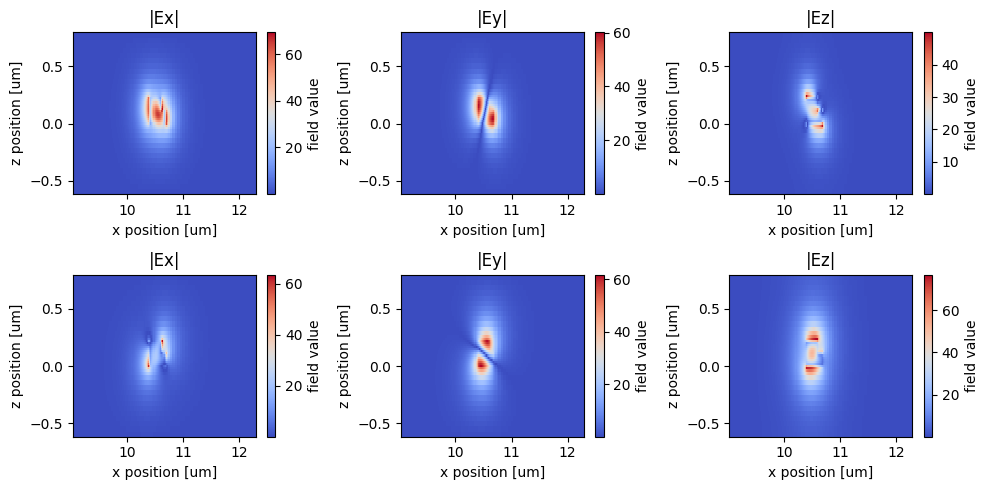

In [10]:
def plot_field_components(mode_data):
    f, ax = plt.subplots(2, 3, figsize=(10, 5), tight_layout=True)
    cmap = "coolwarm"
    abs(mode_data.Ex.sel(mode_index=0, f=freq0)).plot(x="x", y="z", ax=ax[0][0], cmap=cmap)
    abs(mode_data.Ey.sel(mode_index=0, f=freq0)).plot(x="x", y="z", ax=ax[0][1], cmap=cmap)
    abs(mode_data.Ez.sel(mode_index=0, f=freq0)).plot(x="x", y="z", ax=ax[0][2], cmap=cmap)
    abs(mode_data.Ex.sel(mode_index=1, f=freq0)).plot(x="x", y="z", ax=ax[1][0], cmap=cmap)
    abs(mode_data.Ey.sel(mode_index=1, f=freq0)).plot(x="x", y="z", ax=ax[1][1], cmap=cmap)
    abs(mode_data.Ez.sel(mode_index=1, f=freq0)).plot(x="x", y="z", ax=ax[1][2], cmap=cmap)

    ax[0][0].set_title("|Ex|")
    ax[0][1].set_title("|Ey|")
    ax[0][2].set_title("|Ez|")
    ax[1][0].set_title("|Ex|")
    ax[1][1].set_title("|Ey|")
    ax[1][2].set_title("|Ez|")


plot_field_components(mode_data_outer)

Efficient mode conversion from the inner bend to the outer bend is achieved when the phase matching condition is met. For waveguide bends, the phase matching condition is given by the equal optical path length (OPL). That is, $N_1k_0R_1\theta = N_2k_0R_2\theta$, where $N_1$ and $N_2$ are the effective indices of the inner bend mode and outer bend mode, $k_0$ is the free space wave vector, $R_1$ and $R_2$ are the inner bend radius and outer bend radius, and $\theta$ is the angle of the bend. Let's check the OPLs of the second mode (TM) at the inner waveguide to the first mode (TE) at the outer waveguide to see if they match. To do so, first compute the OPLs for the outer waveguide as we have solved for the modes.

In [11]:
# extract effective indices
n_eff_outer = mode_data_outer.n_eff.values

# compute OPLs
OPL_outer = n_eff_outer * (R1 + W1 / 2 + Wg + W3 / 2)

Then we will do the same for the inner bend.

16:41:07 PST Mode solver created with                                           
             task_id='fdve-2298dba7-9470-4b3e-a0d2-a34cdffd6f82',               
             solver_id='mo-366dcfb7-8133-439a-bf68-3974c8829cf9'.

Output()

Output()

16:41:10 PST Mode solver status: queued

16:41:25 PST Mode solver status: running

16:41:46 PST Mode solver status: success

Output()

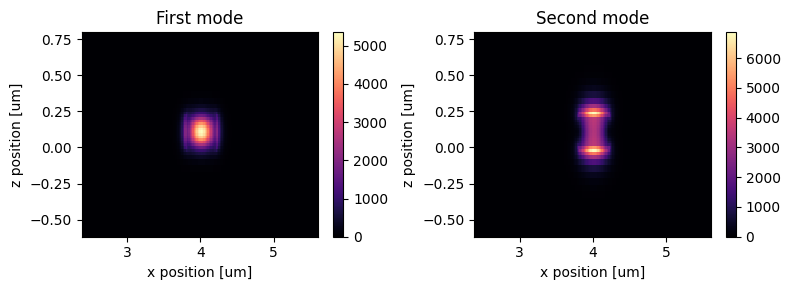

In [12]:
mode_solver = ModeSolver(
    simulation=sim_tm,
    plane=td.Box(center=mode_monitor_through.center, size=mode_monitor_through.size),
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data_inner = run_mode_solver(mode_solver)

plot_field_intensity(mode_data_inner)

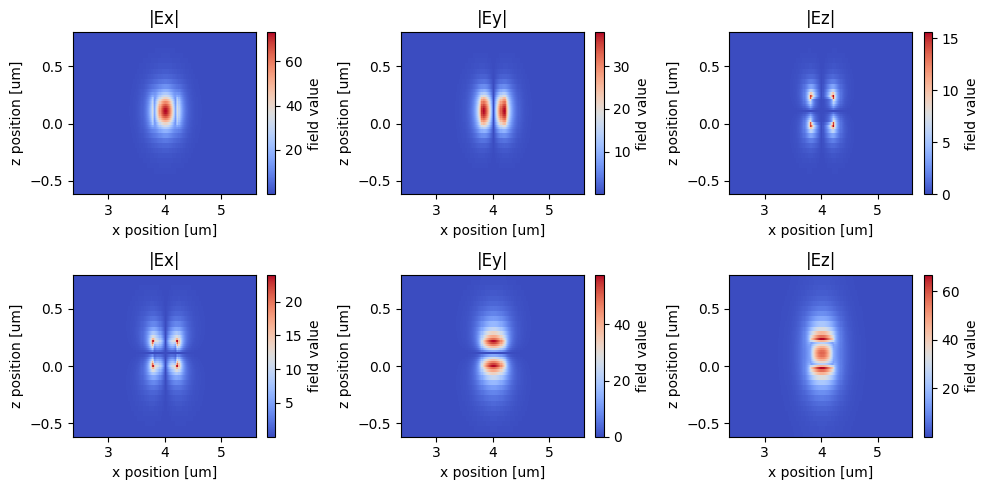

In [13]:
plot_field_components(mode_data_inner)

Calculate the OPLs for the inner waveguide and plot them as well as the OPLs for the outer waveguide. We see that the OPL of the TM mode on the inner bend (red curve) closely matches the OPL of the TE mode on the outer bend (blue dashed curve).

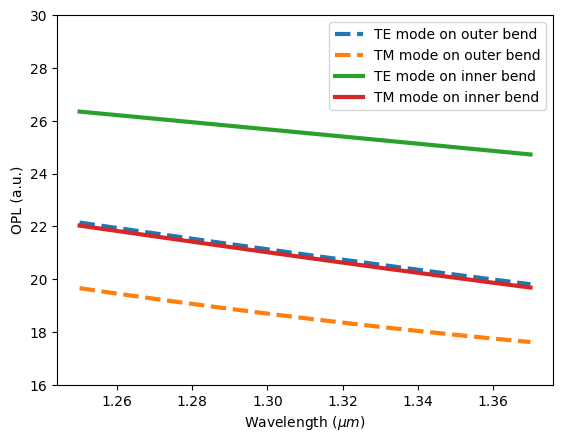

In [14]:
n_eff_inner = mode_data_inner.n_eff.values
OPL_inner = n_eff_inner * R1

# plot calculated OPLs
plt.plot(ldas, OPL_outer[:, 0], linewidth=3, linestyle="--", label="TE mode on outer bend")
plt.plot(ldas, OPL_outer[:, 1], linewidth=3, linestyle="--", label="TM mode on outer bend")
plt.plot(ldas, OPL_inner[:, 0], linewidth=3, label="TE mode on inner bend")
plt.plot(ldas, OPL_inner[:, 1], linewidth=3, label="TM mode on inner bend")
plt.legend()
plt.ylim(16, 30)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("OPL (a.u.)")
plt.show()

## Running the TM Simulation

Now that we have confirmed the design from a mode analysis perspective, we need to verify the device performance using 3D FDTD. We are ready to submit the simulation job to the server. Before running the simulation, we can get a cost estimation using `estimate_cost`. This prevents us from accidentally running large jobs that we set up by mistake. The estimated cost is the maximum cost corresponding to running all the time steps.

In [15]:
job_tm = web.Job(simulation=sim_tm, task_name="psr_tm", verbose=True)
estimated_cost = web.estimate_cost(job_tm.task_id)

16:41:50 PST Created task 'psr_tm' with task_id                                 
             'fdve-032e06f8-f635-409f-a8aa-f5eddfff5657' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=26444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-032e06f8-f635-409f-a8aa-f5eddfff5657\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=741184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-032e06f8-f635-409f-a8aa-f5eddfff5657\taskId]8;;\]8;id=26444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-032e06f8-f635-409f-a8aa-f5eddfff5657\=]8;;\]8;id=981843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-032e06f8-f635-409f-a8aa-f5eddfff5657\fdve]8;;\]8;id=26444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-032e06f8-f635-409f-a8aa-f5eddfff5657\-032e06f8-f63]8;;\
             ]8;id=26444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-032e06f8-f635-409f-a8aa-f5eddfff5657\5-409f-a8aa-f5eddfff5657']8;;\.

Output()

16:41:51 PST Maximum FlexCredit cost: 1.889. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

The cost is reasonable so we can run the simulation.

In [16]:
sim_data_tm = job_tm.run(path="data/simulation_data.hdf5")

             status = success

Output()

16:41:54 PST loading simulation from data/simulation_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

## TM Result Visualization

After the simulation is complete, we first plot the field distribution. From the field distribution, we observe an efficient coupling from the inner bend to the outer bend.

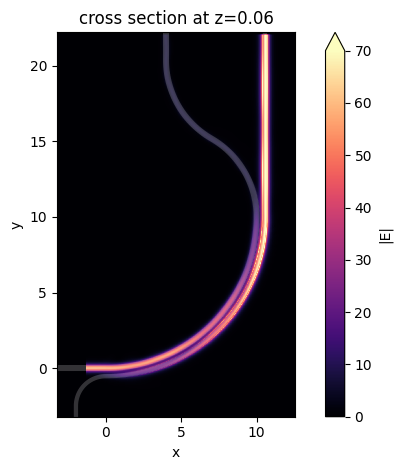

In [17]:
sim_data_tm.plot_field(
    field_monitor_name="field", field_name="E", val="abs", f=freq0, vmin=0, vmax=70
)
plt.show()

More quantitatively, we plot the mode conversion efficiencies. Indeed, a high TM to TE mode conversion at the cross port is observed as desired. 

16:41:56 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

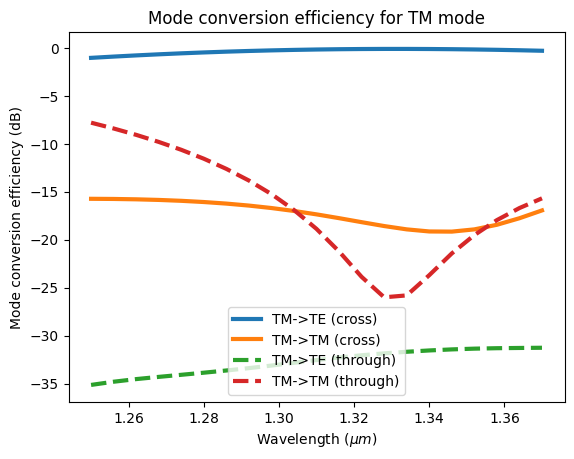

In [18]:
def plot_conversion_efficiency(sim_data, pol):
    # extract the transmission data from the mode monitor
    T_cross_te = np.abs(sim_data["cross"].amps.sel(mode_index=0, direction="+")) ** 2
    T_cross_tm = np.abs(sim_data["cross"].amps.sel(mode_index=1, direction="+")) ** 2

    T_through_te = np.abs(sim_data["through"].amps.sel(mode_index=0, direction="+")) ** 2
    T_through_tm = np.abs(sim_data["through"].amps.sel(mode_index=1, direction="+")) ** 2

    # plot transmission
    plt.plot(ldas, 10 * np.log10(T_cross_te), linewidth=3, label=f"{pol}->TE (cross)")
    plt.plot(ldas, 10 * np.log10(T_cross_tm), linewidth=3, label=f"{pol}->TM (cross)")
    plt.plot(
        ldas, 10 * np.log10(T_through_te), linewidth=3, linestyle="--", label=f"{pol}->TE (through)"
    )
    plt.plot(
        ldas, 10 * np.log10(T_through_tm), linewidth=3, linestyle="--", label=f"{pol}->TM (through)"
    )
    plt.legend()
    plt.xlabel("Wavelength ($\mu m$)")
    plt.ylabel("Mode conversion efficiency (dB)")
    plt.title(f"Mode conversion efficiency for {pol} mode")
    plt.show()


plot_conversion_efficiency(sim_data_tm, "TM")

## Running the TE Simulation

Now that we have confirmed the TM to TE polarization rotation of the device, we need to confirm the TE-TE conversion at the through port. The TE mode at the inner waveguide will not couple to the outer waveguide due to the phase matching condition is not met as shown above. 

To run the TE simulation, we only need to update the `mode_index` from `1` to `0` in the [ModeSource](../api/_autosummary/tidy3d.ModeSource.html).

In [19]:
mode_source = mode_source.copy(update={"mode_index": 0})
sim_te = sim_tm.copy(update={"sources": [mode_source]})
sim_data_te = web.run(simulation=sim_te, task_name="psr_te", path="data/simulation_data.hdf5")

16:41:57 PST Created task 'psr_te' with task_id                                 
             'fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=249727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=769139;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\taskId]8;;\]8;id=249727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\=]8;;\]8;id=742458;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\fdve]8;;\]8;id=249727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\-c673301b-39c]8;;\
             ]8;id=249727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\e-4a73-8b69-32dbbfd73e95']8;;\.

Output()

16:41:58 PST status = queued

Output()

16:42:01 PST status = preprocess

16:42:04 PST Maximum FlexCredit cost: 1.889. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:43:48 PST early shutoff detected at 96%, exiting.

             status = postprocess

Output()

16:43:52 PST status = success

             View simulation result at                                          
             ]8;id=879912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=761487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\taskId]8;;\]8;id=879912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\=]8;;\]8;id=586600;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\fdve]8;;\]8;id=879912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\-c673301b-39c]8;;\
             ]8;id=879912;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c673301b-39ce-4a73-8b69-32dbbfd73e95\e-4a73-8b69-32dbbfd73e95']8;;\.

Output()

16:43:54 PST loading simulation from data/simulation_data.hdf5

16:43:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

## TE Result Visualization

Field distribution shows minimal coupling to the outer waveguide.

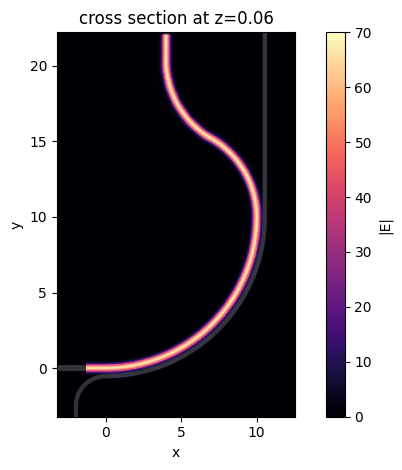

In [20]:
sim_data_te.plot_field(
    field_monitor_name="field", field_name="E", val="abs", f=freq0, vmin=0, vmax=70
)
plt.show()

As expected, the input TE mode stays at the inner waveguide as TE polarization. Both simulations confirm the good performance of the PSR design.

16:43:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

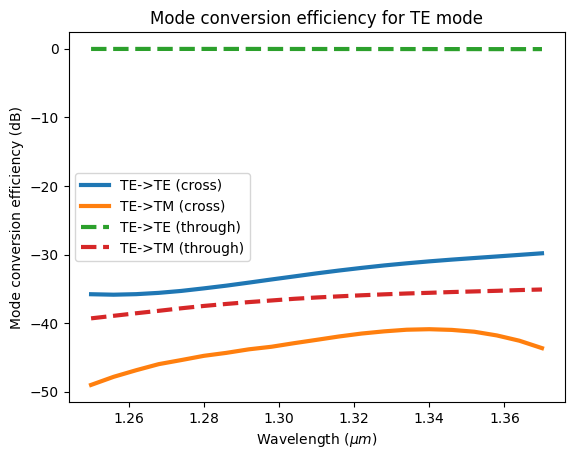

In [21]:
plot_conversion_efficiency(sim_data_te, "TE")

 > For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it. 